In [1]:
from fastapi import FastAPI, HTTPException
from fastapi.middleware.cors import CORSMiddleware
from pydantic import BaseModel
import dotenv
import pendulum
from sqlalchemy import create_engine, asc, desc, or_
from sqlalchemy.orm import sessionmaker
from config import Settings
from models import MessageSql
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates
from datetime import timedelta
import numpy as np
import plotly.express as px
import plotly.graph_objects as go

settings = Settings(_env_file=dotenv.find_dotenv())
valid_password = settings.thermostat_api_key.get_secret_value()
engine = create_engine(settings.db_url.get_secret_value())
Session = sessionmaker(bind=engine)

session = Session()
timezone = "America/New_York"
start = pendulum.datetime(2024, 10, 29, 0, 0, tz=timezone)
end = pendulum.datetime(2024, 10, 29, 23, 30, tz=timezone)
start_ms = int(start.timestamp() * 1000)
end_ms = int(end.timestamp() * 1000)

messages = session.query(MessageSql).filter(
    MessageSql.from_alias.like(f'%fir%'),
    or_(
        MessageSql.message_type_name == "batched.readings",
        MessageSql.message_type_name == "report"
        ),
    MessageSql.message_persisted_ms >= start_ms,
    MessageSql.message_persisted_ms <= end_ms,
).order_by(asc(MessageSql.message_persisted_ms)).all()

print(len(messages))

281


In [2]:
# data_channels = session.query(DataChannelSql).filter(
#     MessageSql.from_alias.like(f'%fir%'),
#     or_(
#         MessageSql.message_type_name == "batched.readings",
#         MessageSql.message_type_name == "report"
#         ),
#     MessageSql.message_persisted_ms >= start_ms,
#     MessageSql.message_persisted_ms <= end_ms,
# ).order_by(asc(MessageSql.message_persisted_ms)).all()

In [3]:
# readings = session.query(ReadingSql).filter(
#     MessageSql.from_alias.like(f'%fir%'),
#     or_(
#         MessageSql.message_type_name == "batched.readings",
#         MessageSql.message_type_name == "report"
#         ),
#     MessageSql.message_persisted_ms >= start_ms,
#     MessageSql.message_persisted_ms <= end_ms,
# ).order_by(asc(MessageSql.message_persisted_ms)).all()

In [4]:
def to_fahrenheit(t):
    return t*9/5+32

In [5]:
gradient = plt.get_cmap('coolwarm', 4)
buffer_colors = {
    'buffer-depth1': gradient(3),
    'buffer-depth2': gradient(2),
    'buffer-depth3': gradient(1),
    'buffer-depth4': gradient(0)
    }

gradient = plt.get_cmap('coolwarm', 12)
storage_colors = {
    'tank1-depth1': gradient(11),
    'tank1-depth2': gradient(10),
    'tank1-depth3': gradient(9),
    'tank1-depth4': gradient(8),
    'tank2-depth1': gradient(7),
    'tank2-depth2': gradient(6),
    'tank2-depth3': gradient(5),
    'tank2-depth4': gradient(4),
    'tank3-depth1': gradient(3),
    'tank3-depth2': gradient(2),
    'tank3-depth3': gradient(1),
    'tank3-depth4': gradient(0),
    }

In [6]:
selected_plot_keys = [
    'hp-lwt', 'hp-ewt', 'hp-odu-pwr', 'hp-idu-pwr', 'primary-pump-pwr', 
    'dist-swt', 'dist-rwt', 'zone_heat_calls',
    'store-hot-pipe', 'store-cold-pipe', 'store-pump-pwr',
    'buffer-cold-pipe', 'buffer-hot-pipe', 'dist-pump-pwr', 'buffer-depths', 'storage-depths']

In [7]:
channels = {}
for message in messages:
    for channel in message.payload['ChannelReadingList']:
        # Find the channel name
        if message.message_type_name == 'report':
            channel_name = channel['ChannelName']
        elif message.message_type_name == 'batched.readings':
            for dc in message.payload['DataChannelList']:
                if dc['Id'] == channel['ChannelId']:
                    channel_name = dc['Name']
        # Store the values and times for the channel
        if channel_name not in channels:
            channels[channel_name] = {
                'values': channel['ValueList'],
                'times': channel['ScadaReadTimeUnixMsList']
            }
        else:
            channels[channel_name]['values'].extend(channel['ValueList'])
            channels[channel_name]['times'].extend(channel['ScadaReadTimeUnixMsList'])

# Sort values according to time
for key in channels.keys():
    sorted_times_values = sorted(zip(channels[key]['times'], channels[key]['values']))
    sorted_times, sorted_values = zip(*sorted_times_values)
    channels[key]['values'] = list(sorted_values)
    channels[key]['times'] = pd.to_datetime(list(sorted_times), unit='ms', utc=True)
    channels[key]['times'] = channels[key]['times'].tz_convert('America/New_York')
    channels[key]['times'] = [x.replace(tzinfo=None) for x in channels[key]['times']]

    # Check the length
    if len(channels[key]['times']) != len(channels[key]['values']):
        print(f"Length mismatch in channel: {key}")
        selected_plot_keys.remove(key)
            
# Find all zone channels
zones = {}
first_times, process_heatcalls = None, False
for channel_name in channels.keys():
    if 'zone' in channel_name and 'gw-temp' not in channel_name:
        if 'state' not in channel_name:
            channels[channel_name]['values'] = [x/1000 for x in channels[channel_name]['values']]
        else:
            # Round times to the minute
            channels[channel_name]['times'] = pd.Series(channels[channel_name]['times']).dt.round('s').tolist()
            if first_times is None:
                first_times = channels[channel_name]['times']
            if channels[channel_name]['times'] != first_times:
                process_heatcalls = True
        zone_name = channel_name.split('-')[0]
        if zone_name not in zones:
            zones[zone_name] = [channel_name]
        else:
            zones[zone_name].append(channel_name)

if process_heatcalls:

    def interpolate_value(state, given_time, channels_copy):
        prev_time = None
        next_time = None
        for existing_time in channels_copy[state]['times']:
            if existing_time < given_time:
                prev_time = channels_copy[state]['times'].index(existing_time)
            elif existing_time > given_time and next_time is None:
                next_time = channels_copy[state]['times'].index(existing_time)
        if prev_time is None or next_time is None:
            return 0
        if channels_copy[state]['values'][prev_time]==1 and channels_copy[state]['values'][next_time]==1:
            return 1
        else:
            return 0

    # Get all timestamps in the zone states
    all_times = []
    for zone in zones:
        for state in [x for x in zones[zone] if 'state' in x]:
            all_times.extend(channels[state]['times'])
    all_times = sorted(list(set(all_times)))

    # Fill in the blanks
    channels_copy = channels.copy()
    for zone in zones:
        for state in [x for x in zones[zone] if 'state' in x]:
            if channels[state]['times'] != all_times:
                values_to_insert = []
                times_to_insert = []
                # Add missing times
                for time in all_times:
                    if time not in channels[state]['times']:
                        values_to_insert.append(0)#interpolate_value(state, time, channels_copy))
                        times_to_insert.append(time)
                channels[state]['times'].extend(times_to_insert)
                channels[state]['values'].extend(values_to_insert)
                # Sort by time again
                sorted_times_values = sorted(zip(channels[state]['times'], channels[state]['values']))
                sorted_times, sorted_values = zip(*sorted_times_values)
                channels[state]['values'] = list(sorted_values)
                channels[state]['times'] = list(sorted_times)

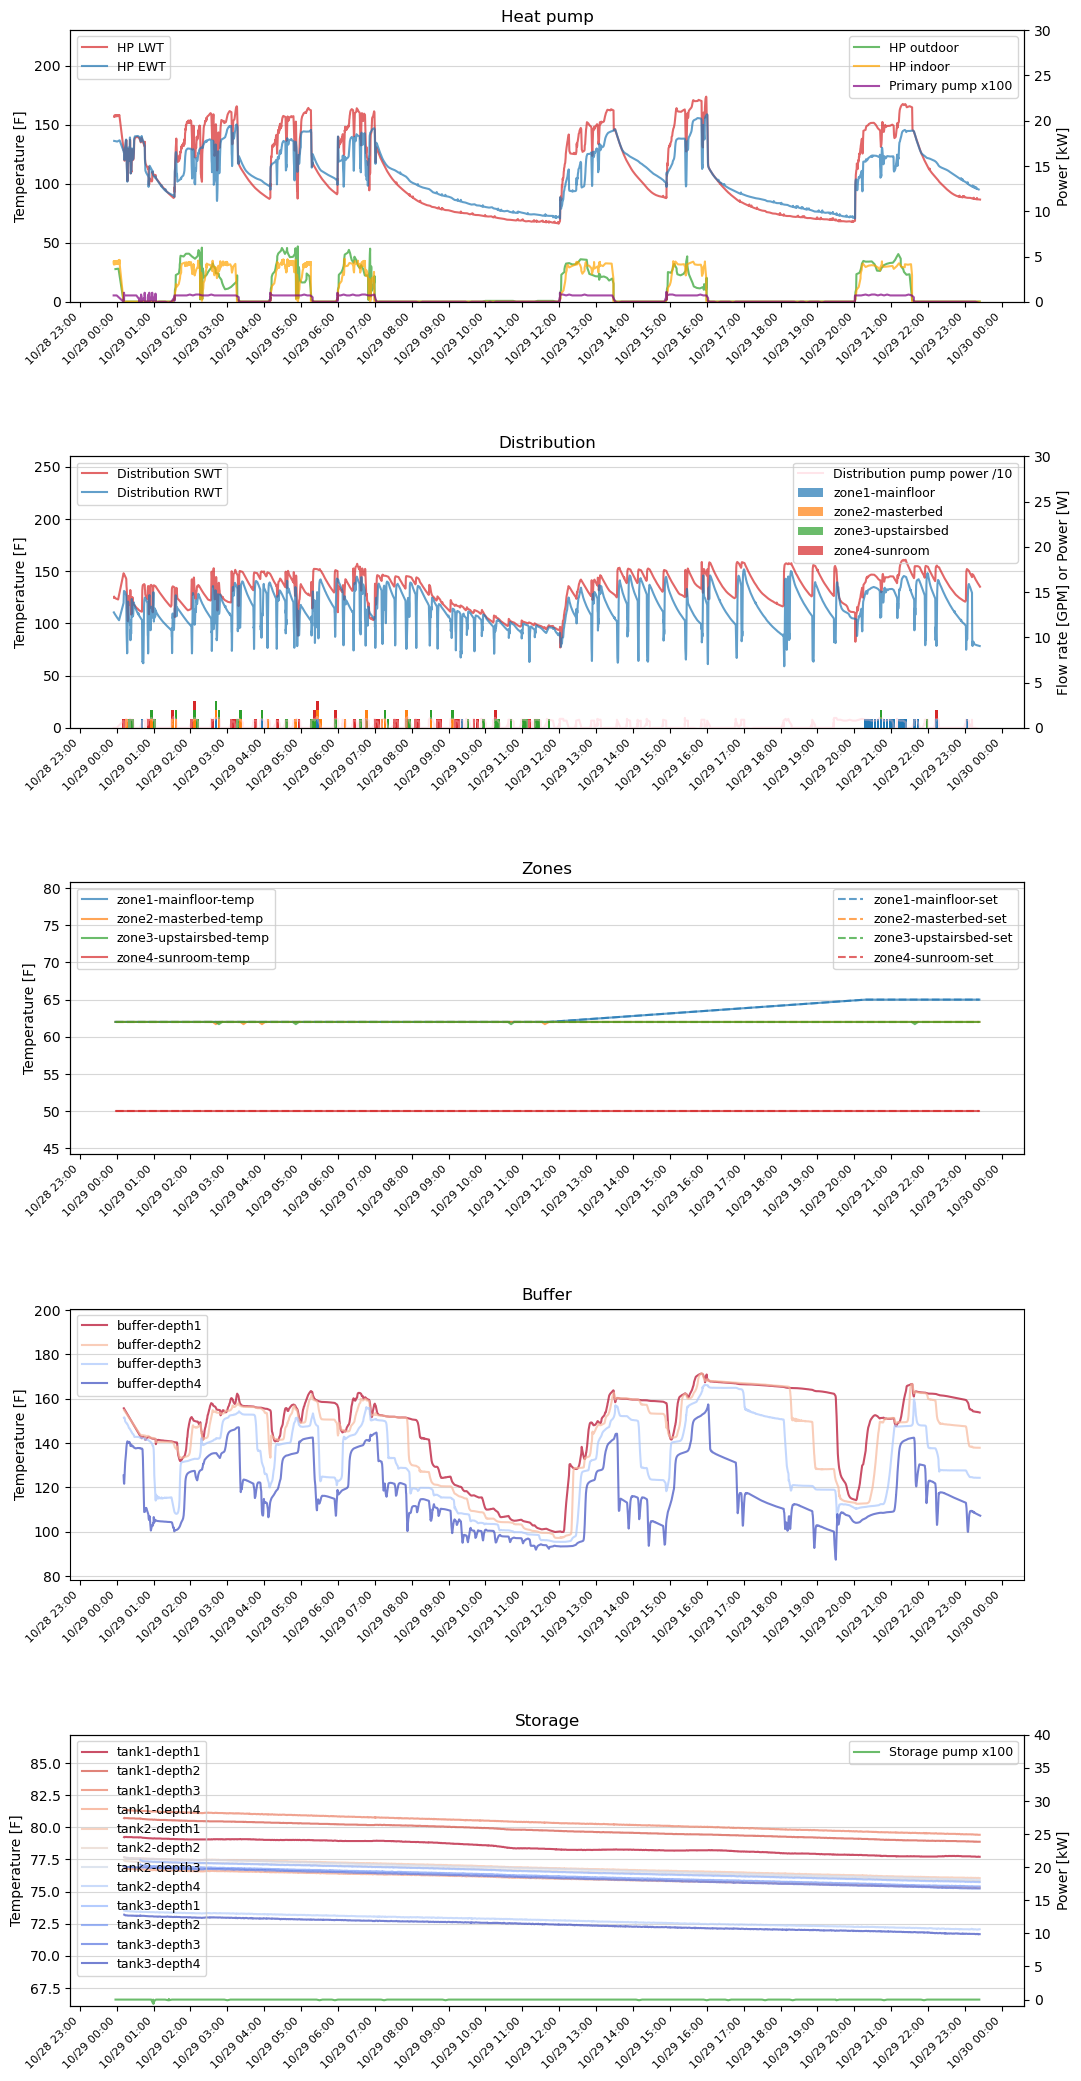

In [15]:
channels = {}
for message in messages:
    for channel in message.payload['ChannelReadingList']:
        # Find the channel name
        if message.message_type_name == 'report':
            channel_name = channel['ChannelName']
        elif message.message_type_name == 'batched.readings':
            for dc in message.payload['DataChannelList']:
                if dc['Id'] == channel['ChannelId']:
                    channel_name = dc['Name']
        # Store the values and times for the channel
        if channel_name not in channels:
            channels[channel_name] = {
                'values': channel['ValueList'],
                'times': channel['ScadaReadTimeUnixMsList']
            }
        else:
            channels[channel_name]['values'].extend(channel['ValueList'])
            channels[channel_name]['times'].extend(channel['ScadaReadTimeUnixMsList'])

# Sort values according to time
for key in channels.keys():
    sorted_times_values = sorted(zip(channels[key]['times'], channels[key]['values']))
    sorted_times, sorted_values = zip(*sorted_times_values)
    channels[key]['values'] = list(sorted_values)
    channels[key]['times'] = pd.to_datetime(list(sorted_times), unit='ms', utc=True)
    channels[key]['times'] = channels[key]['times'].tz_convert('America/New_York')
    channels[key]['times'] = [x.replace(tzinfo=None) for x in channels[key]['times']]

    # Check the length
    if len(channels[key]['times']) != len(channels[key]['values']):
        print(f"Length mismatch in channel: {key}")
        selected_plot_keys.remove(key)
            
# Find all zone channels
zones = {}
first_times, process_heatcalls = None, False
for channel_name in channels.keys():
    if 'zone' in channel_name and 'gw-temp' not in channel_name:
        if 'state' not in channel_name:
            channels[channel_name]['values'] = [x/1000 for x in channels[channel_name]['values']]
        else:
            # Round times to the minute
            channels[channel_name]['times'] = pd.Series(channels[channel_name]['times']).dt.round('s').tolist()
            if first_times is None:
                first_times = channels[channel_name]['times']
            if channels[channel_name]['times'] != first_times:
                process_heatcalls = True
        zone_name = channel_name.split('-')[0]
        if zone_name not in zones:
            zones[zone_name] = [channel_name]
        else:
            zones[zone_name].append(channel_name)

if process_heatcalls:

    def interpolate_value(state, given_time, channels_copy):
        prev_time = None
        next_time = None
        for existing_time in channels_copy[state]['times']:
            if existing_time < given_time:
                prev_time = channels_copy[state]['times'].index(existing_time)
            elif existing_time > given_time and next_time is None:
                next_time = channels_copy[state]['times'].index(existing_time)
        if prev_time is None or next_time is None:
            return 0
        if channels_copy[state]['values'][prev_time]==1 and channels_copy[state]['values'][next_time]==1:
            return 1
        else:
            return 0

    # Get all timestamps in the zone states
    all_times = []
    for zone in zones:
        for state in [x for x in zones[zone] if 'state' in x]:
            all_times.extend(channels[state]['times'])
    all_times = sorted(list(set(all_times)))

    # Fill in the blanks
    channels_copy = channels.copy()
    for zone in zones:
        for state in [x for x in zones[zone] if 'state' in x]:
            if channels[state]['times'] != all_times:
                values_to_insert = []
                times_to_insert = []
                # Add missing times
                for time in all_times:
                    if time not in channels[state]['times']:
                        values_to_insert.append(interpolate_value(state, time, channels_copy))
                        times_to_insert.append(time)
                channels[state]['times'].extend(times_to_insert)
                channels[state]['values'].extend(values_to_insert)
                # Sort by time again
                sorted_times_values = sorted(zip(channels[state]['times'], channels[state]['values']))
                sorted_times, sorted_values = zip(*sorted_times_values)
                channels[state]['values'] = list(sorted_values)
                channels[state]['times'] = list(sorted_times)

fig, ax = plt.subplots(5,1, figsize=(12,22), sharex=True)
line_style = '-x' if 'show-points'in selected_plot_keys else '-'

# --------------------------------------
# PLOT 1
# --------------------------------------

ax[0].set_title('Heat pump')

# Temperature
temp_plot = False
if 'hp-lwt' in selected_plot_keys:
    temp_plot = True
    channels['hp-lwt']['values'] = [to_fahrenheit(x/1000) for x in channels['hp-lwt']['values']]
    ax[0].plot(channels['hp-lwt']['times'], channels['hp-lwt']['values'], line_style, color='tab:red', alpha=0.7, label='HP LWT')
if 'hp-ewt' in selected_plot_keys:
    temp_plot = True
    channels['hp-ewt']['values'] = [to_fahrenheit(x/1000) for x in channels['hp-ewt']['values']]
    ax[0].plot(channels['hp-ewt']['times'], channels['hp-ewt']['values'], line_style, color='tab:blue', alpha=0.7, label='HP EWT')
if temp_plot:
    if 'hp-odu-pwr' in selected_plot_keys or 'hp-idu-pwr' in selected_plot_keys or 'primary-pump-pwr' in selected_plot_keys:
        ax[0].set_ylim([0,230])
    else:
        lower_bound = ax[0].get_ylim()[0] - 5
        upper_bound = ax[0].get_ylim()[1] + 25
        ax[0].set_ylim([lower_bound, upper_bound])
    ax[0].set_ylabel('Temperature [F]')
    legend = ax[0].legend(loc='upper left', fontsize=9)
    legend.get_frame().set_facecolor('none')
    ax20 = ax[0].twinx()
else:
    ax20 = ax[0]

# Power
power_plot = False
if 'hp-odu-pwr' in selected_plot_keys:
    power_plot = True
    channels['hp-odu-pwr']['values'] = [x/1000 for x in channels['hp-odu-pwr']['values']]
    ax20.plot(channels['hp-odu-pwr']['times'], channels['hp-odu-pwr']['values'], line_style, color='tab:green', alpha=0.7, label='HP outdoor')
if 'hp-idu-pwr' in selected_plot_keys:
    power_plot = True
    channels['hp-idu-pwr']['values'] = [x/1000 for x in channels['hp-idu-pwr']['values']]
    ax20.plot(channels['hp-idu-pwr']['times'], channels['hp-idu-pwr']['values'], line_style, color='orange', alpha=0.7, label='HP indoor')
if 'primary-pump-pwr' in selected_plot_keys:
    power_plot = True
    channels['primary-pump-pwr']['values'] = [x/10 for x in channels['primary-pump-pwr']['values']]
    ax20.plot(channels['primary-pump-pwr']['times'], channels['primary-pump-pwr']['values'], line_style, 
            color='purple', alpha=0.7, label='Primary pump x100')
if power_plot:
    if temp_plot:
        ax20.set_ylim([0,30])
    else:
        upper_bound = ax[0].get_ylim()[1] + 2.5
        ax[0].set_ylim([-1, upper_bound])
    ax20.set_ylabel('Power [kW]')
    legend = ax20.legend(loc='upper right', fontsize=9)
    legend.get_frame().set_facecolor('none')
else:
    ax20.set_yticks([])

# --------------------------------------
# PLOT 2
# --------------------------------------

ax[1].set_title('Distribution')

# Temperature
temp_plot = False
if 'dist-swt' in selected_plot_keys:  
    temp_plot = True    
    channels['dist-swt']['values'] = [to_fahrenheit(x/1000) for x in channels['dist-swt']['values']]
    ax[1].plot(channels['dist-swt']['times'], channels['dist-swt']['values'], line_style, color='tab:red', alpha=0.7, label='Distribution SWT')
if 'dist-rwt' in selected_plot_keys:  
    temp_plot = True    
    channels['dist-rwt']['values'] = [to_fahrenheit(x/1000) for x in channels['dist-rwt']['values']]
    ax[1].plot(channels['dist-rwt']['times'], channels['dist-rwt']['values'], line_style, color='tab:blue', alpha=0.7, label='Distribution RWT')
if temp_plot:
    ax[1].set_ylabel('Temperature [F]')
    if 'zone_heat_calls' in selected_plot_keys:
        ax[1].set_ylim([0,260])
    else:
        lower_bound = ax[1].get_ylim()[0] - 5
        upper_bound = ax[1].get_ylim()[1] + 25
        ax[1].set_ylim([lower_bound, upper_bound])
    legend = ax[1].legend(loc='upper left', fontsize=9)
    legend.get_frame().set_facecolor('none')
    ax21 = ax[1].twinx()
else:
    ax21 = ax[1]

# Distribution pump power
power_plot = False   
if 'dist-pump-pwr'in selected_plot_keys:
    power_plot = True
    ax21.plot(channels['dist-pump-pwr']['times'], [x/10 for x in channels['dist-pump-pwr']['values']], alpha=0.4, 
            color='pink', label='Distribution pump power /10') 
if 'dist-flow' in selected_plot_keys:
    power_plot = True
    ax21.plot(channels['dist-flow']['times'], [x/100 for x in channels['dist-flow']['values']], alpha=0.4, 
            color='tab:purple', label='Distribution flow') 

# Zone heat calls
num_zones = len(zones.keys())
height_of_stack = 0
stacked_values = None
scale = 1 #if 'dist-flow' in selected_plot_keys else 0.25
if 'zone_heat_calls' in selected_plot_keys:
    for zone in zones:
        for key in [x for x in zones[zone] if 'state' in x]:
            if stacked_values is None:
                stacked_values = np.zeros(len(channels[key]['times']))
            if len(stacked_values) != len(channels[key]['values']):
                height_of_stack += scale
                stacked_values = np.ones(len(channels[key]['times'])) * height_of_stack
            ax21.bar(channels[key]['times'], [x*scale for x in channels[key]['values']], alpha=0.7, bottom=stacked_values, 
                        label=key.replace('-state',''), width=0.003)
            stacked_values += [x*scale for x in channels[key]['values']]    

if temp_plot and power_plot:
    if 'dist-flow' in selected_plot_keys:
        upper_bound = max(channels['dist-flow']['values'])/100 * 2.5
    else:
        upper_bound = max(channels['dist-pump-pwr']['values']) * 2.5
    ax21.set_ylim([0,upper_bound])
    ax21.set_ylabel('Flow rate [GPM] or Power [W]')
elif temp_plot and not power_plot:
    upper_bound = num_zones * scale / 0.3
    ax21.set_ylim([0,upper_bound])
    ax21.set_ylabel('Heat calls')
elif not temp_plot and power_plot:
    upper_bound = (max(channels['dist-pump-pwr']['values']) + 10)/10
    ax21.set_ylim([0,upper_bound])
    ax21.set_ylabel('Flow rate [GPM] or Power [W]')
elif not temp_plot and not power_plot:
    upper_bound = num_zones * scale
    ax21.set_ylim([0,upper_bound])
    ax21.set_ylabel('Heat calls')
    ax21.set_yticks([])

legend = ax21.legend(loc='upper right', fontsize=9)
legend.get_frame().set_facecolor('none')


# --------------------------------------
# PLOT 3
# --------------------------------------
    
ax[2].set_title('Zones')
ax22 = ax[2].twinx()

colors = {}
for zone in zones:
    for temp in zones[zone]:
        if 'temp' in temp:
            color = ax[2].plot(channels[temp]['times'], channels[temp]['values'], line_style, label=temp, alpha=0.7)[0].get_color()
            colors[temp] = color
        elif 'set' in temp:
            base_temp = temp.replace('-set', '-temp')
            if base_temp in colors:
                ax22.plot(channels[temp]['times'], channels[temp]['values'], '-'+line_style, label=temp, 
                            color=colors[base_temp], alpha=0.7)
                
ax[2].set_ylabel('Temperature [F]')
ax22.set_yticks([])
lower_bound = min(ax[2].get_ylim()[0], ax22.get_ylim()[0]) - 5
upper_bound = max(ax[2].get_ylim()[1], ax22.get_ylim()[1]) + 15
ax[2].set_ylim([lower_bound, upper_bound])
ax22.set_ylim([lower_bound, upper_bound])
legend = ax[2].legend(loc='upper left', fontsize=9)
legend.get_frame().set_facecolor('none')
legend = ax22.legend(loc='upper right', fontsize=9)
legend.get_frame().set_facecolor('none')

# --------------------------------------
# PLOT 4
# --------------------------------------

ax[3].set_title('Buffer')

buffer_channels = []
if 'buffer-depths' in selected_plot_keys:
    buffer_channels = sorted([key for key in channels.keys() if 'buffer-depth' in key and 'micro-v' not in key])
    for buffer_channel in buffer_channels:
        channels[buffer_channel]['values'] = [to_fahrenheit(x/1000) for x in channels[buffer_channel]['values']]
        ax[3].plot(channels[buffer_channel]['times'], channels[buffer_channel]['values'], line_style, 
                color=buffer_colors[buffer_channel], alpha=0.7, label=buffer_channel)

if not buffer_channels:
    if 'buffer-hot-pipe' in selected_plot_keys:
        channels['buffer-hot-pipe']['values'] = [to_fahrenheit(x/1000) for x in channels['buffer-hot-pipe']['values']]
        ax[3].plot(channels['buffer-hot-pipe']['times'], channels['buffer-hot-pipe']['values'], line_style, 
                color='tab:red', alpha=0.7, label='Buffer hot pipe')
    if 'buffer-cold-pipe' in selected_plot_keys:
        channels['buffer-cold-pipe']['values'] = [to_fahrenheit(x/1000) for x in channels['buffer-cold-pipe']['values']]
        ax[3].plot(channels['buffer-cold-pipe']['times'], channels['buffer-cold-pipe']['values'], line_style, 
                color='tab:blue', alpha=0.7, label='Buffer cold pipe')

ax[3].set_ylabel('Temperature [F]')
legend = ax[3].legend(loc='upper left', fontsize=9)
legend.get_frame().set_facecolor('none')
lower_bound = ax[3].get_ylim()[0] - 5
upper_bound = ax[3].get_ylim()[1] + 25
ax[3].set_ylim([lower_bound, upper_bound])

# --------------------------------------
# PLOT 5
# --------------------------------------

ax[4].set_title('Storage')

# Temperature
temp_plot = False
tank_channels = []

if 'storage-depths' in selected_plot_keys:
    temp_plot = True
    tank_channels = sorted([key for key in channels.keys() if 'tank' in key and 'micro-v' not in key])
    for tank_channel in tank_channels:
        channels[tank_channel]['values'] = [to_fahrenheit(x/1000) for x in channels[tank_channel]['values']]
        ax[4].plot(channels[tank_channel]['times'], channels[tank_channel]['values'], line_style, 
                color=storage_colors[tank_channel], alpha=0.7, label=tank_channel)

if not tank_channels:
    if 'store-hot-pipe' in selected_plot_keys:
        temp_plot = True
        channels['store-hot-pipe']['values'] = [to_fahrenheit(x/1000) for x in channels['store-hot-pipe']['values']]
        ax[4].plot(channels['store-hot-pipe']['times'], channels['store-hot-pipe']['values'], line_style, 
                color='tab:red', alpha=0.7, label='Storage hot pipe')
    if 'store-cold-pipe' in selected_plot_keys:
        temp_plot = True
        channels['store-cold-pipe']['values'] = [to_fahrenheit(x/1000) for x in channels['store-cold-pipe']['values']]
        ax[4].plot(channels['store-cold-pipe']['times'], channels['store-cold-pipe']['values'], line_style, 
                color='tab:blue', alpha=0.7, label='Storage cold pipe')
        
if temp_plot:
    ax24 = ax[4].twinx()
else:
    ax24 = ax[4]

# Power
power_plot = False
if 'store-pump-pwr' in selected_plot_keys:
    power_plot = True
    channels['store-pump-pwr']['values'] = [x/10 for x in channels['store-pump-pwr']['values']]
    ax24.plot(channels['store-pump-pwr']['times'], channels['store-pump-pwr']['values'], line_style, 
            color='tab:green', alpha=0.7, label='Storage pump x100')

if power_plot:
    if temp_plot:
        ax24.set_ylim([-1,40])
    ax24.set_ylabel('Power [kW]')
    legend = ax24.legend(loc='upper right', fontsize=9)
    legend.get_frame().set_facecolor('none')
else:
    ax24.set_yticks([])

if temp_plot:
    if 'store-pump-pwr' in selected_plot_keys:
        lower_bound = ax[4].get_ylim()[0] - 5 - max(channels['store-pump-pwr']['values'])
    else:
        lower_bound = ax[4].get_ylim()[0] - 5
    upper_bound = ax[4].get_ylim()[1] + 0.5*(ax[4].get_ylim()[1] - ax[4].get_ylim()[0])
    ax[4].set_ylim([lower_bound, upper_bound])
    ax[4].set_ylabel('Temperature [F]')
    legend = ax[4].legend(loc='upper left', fontsize=9)
    legend.get_frame().set_facecolor('none')

# --------------------------------------
# All plots
# --------------------------------------

for axis in ax:
    axis.grid(axis='y', alpha=0.5)
    xlim = axis.get_xlim()
    if (mdates.num2date(xlim[1]) - mdates.num2date(xlim[0]) >= timedelta(hours=4) and 
        mdates.num2date(xlim[1]) - mdates.num2date(xlim[0]) <= timedelta(hours=30)):
        axis.xaxis.set_major_locator(mdates.HourLocator(interval=1))
    elif (mdates.num2date(xlim[1]) - mdates.num2date(xlim[0]) >= timedelta(hours=31) and 
        mdates.num2date(xlim[1]) - mdates.num2date(xlim[0]) <= timedelta(hours=65)):
        axis.xaxis.set_major_locator(mdates.HourLocator(interval=2))
    axis.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d %H:%M'))
    axis.tick_params(axis='x', which='both', labelbottom=True, labelsize=8)
    plt.setp(axis.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout(pad=5.0)
plt.show()

In [9]:
channels = {}
for message in messages:
    for channel in message.payload['ChannelReadingList']:
        # Find the channel name
        if message.message_type_name == 'report':
            channel_name = channel['ChannelName']
        elif message.message_type_name == 'batched.readings':
            for dc in message.payload['DataChannelList']:
                if dc['Id'] == channel['ChannelId']:
                    channel_name = dc['Name']
        # Store the values and times for the channel
        if channel_name not in channels:
            channels[channel_name] = {
                'values': channel['ValueList'],
                'times': channel['ScadaReadTimeUnixMsList']
            }
        else:
            channels[channel_name]['values'].extend(channel['ValueList'])
            channels[channel_name]['times'].extend(channel['ScadaReadTimeUnixMsList'])

# Sort values according to time
for key in channels.keys():
    sorted_times_values = sorted(zip(channels[key]['times'], channels[key]['values']))
    sorted_times, sorted_values = zip(*sorted_times_values)
    channels[key]['values'] = list(sorted_values)
    channels[key]['times'] = pd.to_datetime(list(sorted_times), unit='ms', utc=True)
    channels[key]['times'] = channels[key]['times'].tz_convert('America/New_York')
    channels[key]['times'] = [x.replace(tzinfo=None) for x in channels[key]['times']]

    # Check the length
    if len(channels[key]['times']) != len(channels[key]['values']):
        print(f"Length mismatch in channel: {key}")
        selected_plot_keys.remove(key)
            
# Find all zone channels
zones = {}
first_times, process_heatcalls = None, False
for channel_name in channels.keys():
    if 'zone' in channel_name and 'gw-temp' not in channel_name:
        if 'state' not in channel_name:
            channels[channel_name]['values'] = [x/1000 for x in channels[channel_name]['values']]
        else:
            # Round times to the minute
            channels[channel_name]['times'] = pd.Series(channels[channel_name]['times']).dt.round('s').tolist()
            if first_times is None:
                first_times = channels[channel_name]['times']
            if channels[channel_name]['times'] != first_times:
                process_heatcalls = True
        zone_name = channel_name.split('-')[0]
        if zone_name not in zones:
            zones[zone_name] = [channel_name]
        else:
            zones[zone_name].append(channel_name)

if process_heatcalls:

    def interpolate_value(state, given_time, channels_copy):
        prev_time = None
        next_time = None
        for existing_time in channels_copy[state]['times']:
            if existing_time < given_time:
                prev_time = channels_copy[state]['times'].index(existing_time)
            elif existing_time > given_time and next_time is None:
                next_time = channels_copy[state]['times'].index(existing_time)
        if prev_time is None or next_time is None:
            return 0
        if channels_copy[state]['values'][prev_time]==1 and channels_copy[state]['values'][next_time]==1:
            return 1
        else:
            return 0

    # Get all timestamps in the zone states
    all_times = []
    for zone in zones:
        for state in [x for x in zones[zone] if 'state' in x]:
            all_times.extend(channels[state]['times'])
    all_times = sorted(list(set(all_times)))

    # Fill in the blanks
    channels_copy = channels.copy()
    for zone in zones:
        for state in [x for x in zones[zone] if 'state' in x]:
            if channels[state]['times'] != all_times:
                values_to_insert = []
                times_to_insert = []
                # Add missing times
                for time in all_times:
                    if time not in channels[state]['times']:
                        values_to_insert.append(interpolate_value(state, time, channels_copy))
                        times_to_insert.append(time)
                channels[state]['times'].extend(times_to_insert)
                channels[state]['values'].extend(values_to_insert)
                # Sort by time again
                sorted_times_values = sorted(zip(channels[state]['times'], channels[state]['values']))
                sorted_times, sorted_values = zip(*sorted_times_values)
                channels[state]['values'] = list(sorted_values)
                channels[state]['times'] = list(sorted_times)

In [10]:
# fig = go.Figure()
# fig.add_trace(go.Scatter(x=channels['hp-lwt']['times'], y=channels['hp-lwt']['values'], mode='lines', name='Line 1'))
# fig.show()

In [11]:
# --------------------------------------
# PLOT 1
# --------------------------------------

fig = go.Figure()
fig.update_xaxes(showgrid=False)

# Temperature
temp_plot = False
if 'hp-lwt' in selected_plot_keys:
    temp_plot = True
    yf = [to_fahrenheit(x/1000) for x in channels['hp-lwt']['values']]
    fig.add_trace(go.Scatter(x=channels['hp-lwt']['times'], y=yf, 
                            mode='lines', opacity=0.7,
                            line=dict(color='red', dash='solid'),
                            name='HP LWT'))
if 'hp-ewt' in selected_plot_keys:
    temp_plot = True
    yf = [to_fahrenheit(x/1000) for x in channels['hp-ewt']['values']]

    fig.add_trace(go.Scatter(x=channels['hp-ewt']['times'], y=yf, 
                            mode='lines', opacity=0.7,
                            line=dict(color='blue', dash='solid'),
                            name='HP EWT'))

if temp_plot:
    if 'hp-odu-pwr' in selected_plot_keys or 'hp-idu-pwr' in selected_plot_keys or 'primary-pump-pwr' in selected_plot_keys:
        fig.update_yaxes(range=[0, 260])
    fig.update_layout(yaxis=dict(title='Temperature [F]', zeroline=False))
    fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='LightGray')
    y_axis_power = 'y2'
else:
    y_axis_power = 'y'
    fig.update_layout(yaxis=dict(title='Power [kW]', zeroline=False))
    fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='LightGray')

# Power
power_plot = False
if 'hp-odu-pwr' in selected_plot_keys:
    power_plot = True
    yf = [x/1000 for x in channels['hp-odu-pwr']['values']]
    fig.add_trace(go.Scatter(x=channels['hp-odu-pwr']['times'], y=yf, 
                            mode='lines', opacity=0.7,
                            line=dict(color='green', dash='solid'),
                            name='HP outdoor',
                            yaxis=y_axis_power))

if 'hp-idu-pwr' in selected_plot_keys:
    power_plot = True
    yf = [x/1000 for x in channels['hp-idu-pwr']['values']]
    fig.add_trace(go.Scatter(x=channels['hp-idu-pwr']['times'], y=yf, 
                            mode='lines', opacity=0.7,
                            line=dict(color='orange', dash='solid'),
                            name='HP indoor',
                            yaxis=y_axis_power))
    
if 'primary-pump-pwr' in selected_plot_keys:
    power_plot = True
    yf = [x/10 for x in channels['primary-pump-pwr']['values']]
    fig.add_trace(go.Scatter(x=channels['primary-pump-pwr']['times'], y=yf, 
                            mode='lines', opacity=0.7,
                            line=dict(color='purple', dash='solid'),
                            name='Primary pump x100',
                            yaxis=y_axis_power))

if power_plot:
    fig.update_layout(yaxis2=dict(title='Power [kW]', overlaying='y', side='right', showgrid=False, zeroline=False, range=[0, 30]))

fig.update_layout(
    title='Heat Pump',
    plot_bgcolor='rgba(0,0,0,0)',
    paper_bgcolor='rgba(0,0,0,0)',
    xaxis=dict(
        mirror=True,
        ticks='outside',
        showline=True,
        linecolor='rgb(42,63,96)',
        ),
    yaxis=dict(
        mirror=True,
        ticks='outside',
        showline=True,
        linecolor='rgb(42,63,96)',
        ),
    yaxis2=dict(
        mirror=True,
        ticks='outside',
        showline=True,
        linecolor='rgb(42,63,96)',
        ),
    legend=dict(
        x=0,
        y=1,
        xanchor='left',
        yanchor='top'
    )
)

fig.write_html("heatpump.html")

# --------------------------------------
# PLOT 2
# --------------------------------------

fig = go.Figure()
fig.update_xaxes(showgrid=False)

fig.update_layout(title='Distribution',
                plot_bgcolor='rgba(0,0,0,0)',
                paper_bgcolor='rgba(0,0,0,0)')

# Temperature
temp_plot = False
if 'dist-swt' in selected_plot_keys:
    temp_plot = True
    yf = [to_fahrenheit(x/1000) for x in channels['dist-swt']['values']]
    fig.add_trace(go.Scatter(x=channels['dist-swt']['times'], y=yf, 
                            mode='lines', opacity=0.7,
                            line=dict(color='red', dash='solid'),
                            name='Distribution SWT'))
if 'dist-rwt' in selected_plot_keys:
    temp_plot = True
    yf = [to_fahrenheit(x/1000) for x in channels['dist-rwt']['values']]
    fig.add_trace(go.Scatter(x=channels['dist-rwt']['times'], y=yf, 
                            mode='lines', opacity=0.7,
                            line=dict(color='blue', dash='solid'),
                            name='Distribution RWT'))
    
if temp_plot:
    if 'zone_heat_calls' in selected_plot_keys:
        fig.update_yaxes(range=[0, 260])
    fig.update_layout(yaxis=dict(title='Temperature [F]', zeroline=False))
    fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='LightGray')
    y_axis_power = 'y2'
else:
    y_axis_power = 'y'
    fig.update_layout(yaxis=dict(title='Power [kW]', zeroline=False))
    fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='LightGray')

# Distribution pump power
power_plot = False   
if 'dist-pump-pwr'in selected_plot_keys:
    power_plot = True
    yf = [x/10 for x in channels['dist-pump-pwr']['values']]
    fig.add_trace(go.Scatter(x=channels['dist-pump-pwr']['times'], y=yf, 
                            mode='lines', opacity=0.7,
                            line=dict(color='pink', dash='solid'),
                            name='Distribution pump power /10',
                            yaxis = y_axis_power))
if 'dist-flow' in selected_plot_keys and 'dist-flow' in channels:
    power_plot = True
    yf = [x/100 for x in channels['dist-flow']['values']]
    fig.add_trace(go.Scatter(x=channels['dist-flow']['times'], y=yf, 
                            mode='lines', opacity=0.4,
                            line=dict(color='purple', dash='solid'),
                            name='Distribution flow',
                            yaxis = y_axis_power))
    
if power_plot:
    fig.update_layout(yaxis2=dict(title='Flow [GPM] or Power [W]', overlaying='y', side='right', showgrid=False, zeroline=False, range=[0, 10]))

fig.update_layout(
    legend=dict(
        x=0,
        y=1,
        xanchor='left',
        yanchor='top'
    )
)

fig.update_layout(
    xaxis=dict(
        mirror=True,
        ticks='outside',
        showline=True,
        linecolor='rgb(42,63,96)',
        ),
    yaxis=dict(
        mirror=True,
        ticks='outside',
        showline=True,
        linecolor='rgb(42,63,96)',
        ),
    yaxis2=dict(
        mirror=True,
        ticks='outside',
        showline=True,
        linecolor='rgb(42,63,96)',
        ),
    legend=dict(
        x=0,
        y=1,
        xanchor='left',
        yanchor='top'
    )
)

fig.write_html("distribution.html")
fig.show()

In [ ]:
# --------------------------------------
# PLOT 3
# --------------------------------------

fig = go.Figure()
fig.update_xaxes(showgrid=False)

fig.update_layout(title='Distribution',
                plot_bgcolor='rgba(0,0,0,0)',
                paper_bgcolor='rgba(0,0,0,0)')

# Zone heat calls
num_zones = len(zones.keys())
if 'zone_heat_calls' in selected_plot_keys:

    y_labels = []

    for zone in zones:
        for key in [x for x in zones[zone] if 'state' in x]:

            y_labels.append(key)
    
            for i in range(len(channels[key]['values'])):
                if channels[key]['values'][i] == 1:
                    y_start = int(key[4]) - 1
                    y_end = int(key[4])
                    x_value = channels[key]['times'][i]

                    zone_colors = ['blue', 'orange', 'green', 'red']
                    zone_color = zone_colors[y_start]

                    fig.add_trace(go.Scatter(
                        x=[x_value, x_value],
                        y=[y_start, y_end],
                        mode='lines',
                        line=dict(color=zone_color, width=2),
                        showlegend=False,
                    ))
            
            fig.add_trace(go.Scatter(
                x=[None], y=[None],  # No actual data
                mode='lines',
                line=dict(color=zone_color, width=2),
                name=key  # Legend entry name
            ))

            # fig.add_annotation(
            #     x=min(channels[key]['times']),
            #     y=y_end - 0.5,
            #     text=key,
            #     showarrow=False,
            #     font=dict(color=zone_color)  # Use the same color for the text
            # )

# fig.update_yaxes(
#     tickvals=[i+0.5 for i in range(len(y_labels))],  # Tick positions
#     ticktext=list(y_labels),  # Labels
# )

fig.update_layout(yaxis=dict(zeroline=False))
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='LightGray')

fig.update_layout(
    xaxis=dict(
        range=[x_min, x_max],
        mirror=True,
        ticks='outside',
        showline=True,
        linecolor='rgb(42,63,96)',
        ),
    yaxis=dict(
        mirror=True,
        ticks='outside',
        showline=True,
        linecolor='rgb(42,63,96)',
        ),
    yaxis2=dict(
        mirror=True,
        ticks='outside',
        showline=True,
        linecolor='rgb(42,63,96)',
        ),
    legend=dict(
        x=0,
        y=1,
        xanchor='left',
        yanchor='top',
    )
)

fig.show()
fig.write_html('heatcalls.html')